## First we are trying to get some code up and running that determines an integral using a RBF discretisation method 

In [1]:
from drt_solver.device import DRT, Measurement
from drt_solver.simulation import Simulation
import jax.numpy as jnp 
import pandas as pd
from jax import vmap

from fitting.optimizer import Optimizer
import matplotlib.pyplot as plt

from drt_solver_old.database import (ZARC, 
                                 gamma_ZARC)

In [2]:
# define the range of log frequencies
log_freq_min = -5.
log_freq_max = 4.

# define the range of log timescales with tau=1/f as in the previous papers
log_tau_min = -4  
log_tau_max = 4   

# number of collocation points in log(freq) and log(tau)
N_freqs = 10*int(log_freq_max-log_freq_min)+1
N_taus = 10*int(log_tau_max-log_tau_min)+1

# freq and tau vectors
freq = jnp.logspace(log_freq_min, log_freq_max, num = N_freqs, endpoint=True)
tau = jnp.flip(jnp.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True))
log_tau_vec = jnp.log(tau)
d_log_tau_vec = jnp.abs(log_tau_vec[1] - log_tau_vec[0])

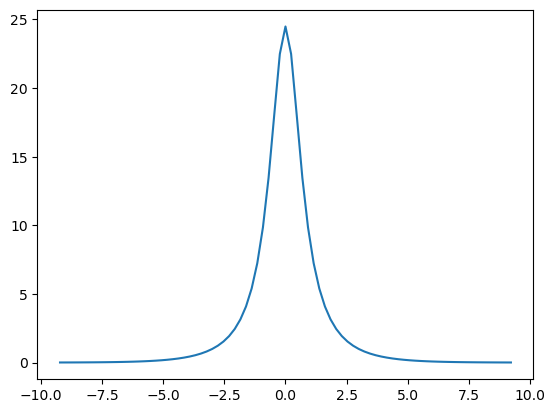

In [3]:
R_inf = 10 # Ohm
R_ct = 50 # Ohm
phi = 0.8 # unitless
tau_0 = 1. # s

L_0 = 0.

gamma_guess = gamma_ZARC(tau, R_ct=R_ct, tau_0=tau_0, phi=phi)
plt.plot(jnp.log(tau), gamma_guess)

In [4]:
x_m = gamma_guess
log_tau_m = log_tau_vec 

In [5]:
def phi(log_tau_m, tau_vec, mu) -> jnp.ndarray:
    return jnp.exp(- (mu * (log_tau_m - tau_vec) )**2 ) 

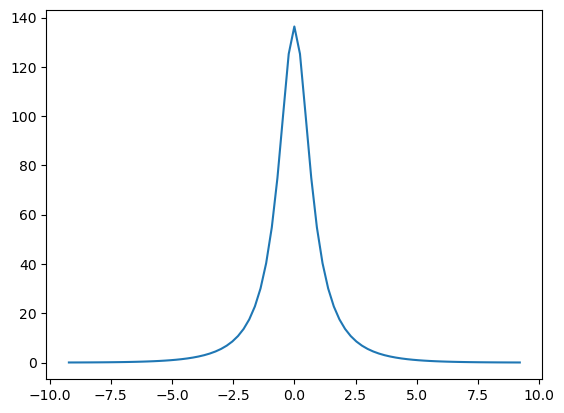

In [6]:
phis = vmap(phi, in_axes=(0, None, None))(log_tau_m, log_tau_m, 0.5)
integrand = (1/2*jnp.pi)*phis
integral = jnp.sum(integrand*d_log_tau_vec, axis = -1)
plt.plot(log_tau_m, integral*x_m)


In [7]:
def A_matrices(f_vec, log_tau_m, mu) -> jnp.ndarray:
    f_idx = jnp.arange(len(f_vec))
    matrix = vmap(vmap(A_element, in_axes=(0, None, None,None)), in_axes=(None, 0, None, None))(f_idx, f_idx, f_vec, log_tau_m)
    return jnp.array(matrix)

def A_element(m, n, f_vec, log_tau): 
    phis = phi(log_tau[n], log_tau, 0.5)
    factor = 1./ (4.*jnp.pi*jnp.exp(2.*(log_tau - log_tau[n] + jnp.log(f_vec[n]) - jnp.log(f_vec[m]))))
    return (factor*phis).sum()

In [8]:

A_matrices(freq, log_tau_m, 0.5).shape



(91, 91)

In [9]:
total = jnp.sum(A*x_m.reshape(1, 1, -1), axis=(-2, -1))
plt.plot(total)

NameError: name 'A' is not defined

In [ ]:

def gaussian( log_tau_m, mu) -> float:
    return jnp.exp(-((mu * (log_tau_m - log_tau_vec)) ** 2))

def A_element( f_m: float, log_tau_n: float) -> float:
    phi = gaussian(log_tau_n, mu=0.5)  # size (n, )
    factor = 1.0 / (1 + (2.0 * jnp.pi * jnp.exp(log_tau_vec) * f_m) ** 2 ) # size (n, )
    d_log_t = jnp.abs(log_tau_vec[1] - log_tau_vec[0])
    return (phi * factor * d_log_t).sum()


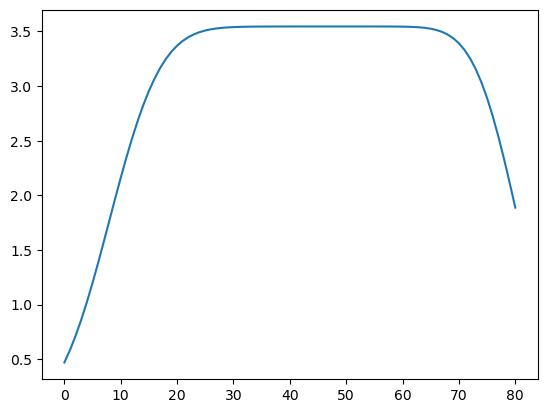

In [ ]:
test = vmap(A_element, in_axes=(None, 0))(freq[10], log_tau_vec)
plt.plot(test)

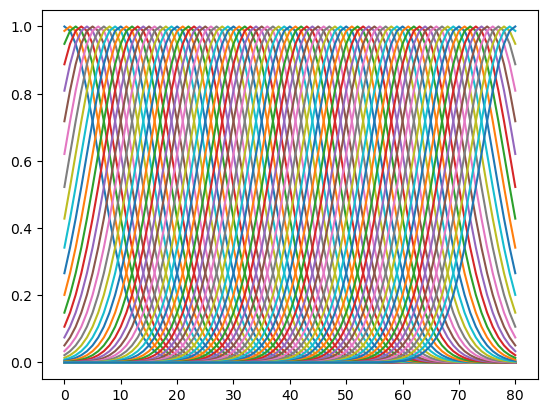

In [ ]:
test2 = vmap(gaussian, in_axes = (0, None))(log_tau_vec, 0.5)
plt.plot(test2)